# Tick occurunce
Trying to win the hackathon at OGH2023 by using Julia. By Maarten Pronk ([@evetion](https://github.com/evetion)).

Notebook to produce a tick occurence prediction. Very simple and quick with only 3 basic assumptions: ticks occur everywhere, but only at specific heights and ecotones. Humans get ticks on  hiking paths. No thought has been given to a time, weather or species pattern, let alone statistical models to account for the (positive) reporting bias. Partial assumption here is that it is very difficult to create a negative testset (absolutely no ticks, can't prove a negative), so we essentially predicts all locations where a tick bite could occur *anytime*.

Input:
- Height map (correlates with colder temperatures and less ticks)
- Rasterized openstreetmap dump of (filtered) Swiss roadset
- Ecotone feature based on changes in landcover

Output:
- Binary classification and its probability

In [1]:
using Rasters, GeoDataFrames, DataFrames, ArchGDAL, MLJ, Plots, StatsBase, GeoArrays
folder = "/Users/evetion/Downloads/prepared"

"/Users/evetion/Downloads/prepared"

## Input data 

### Mask

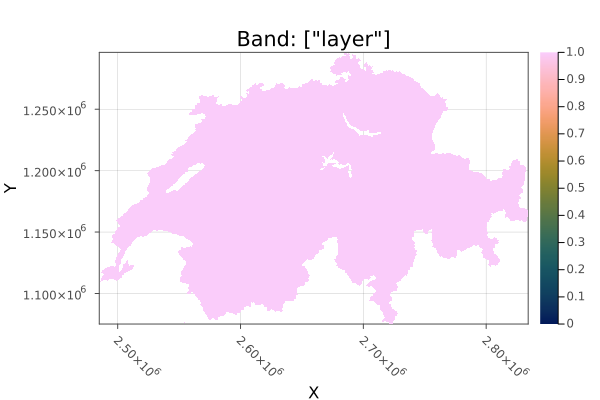

In [3]:
mask = Raster(joinpath(folder, "Mask/Mask.tif"))
plot(mask)

### Roads
Based on our simple assumption, we download the latest OSM dump for Switzerland from https://download.geofabrik.de/europe/switzerland.html, convert it to gpkg with ogr2ogr and read it in here. Note that GeoDataFrames could read the pfb file directly, but it will be much slower than the gpkg.

In [6]:
df = GeoDataFrames.read(joinpath(folder, "roads.gpkg"), "lines")

1589809×3 DataFrame
     Row │ geom                     highway        other_tags                  ⋯
         │ IGeometr…                String         String?                     ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │ Geometry: wkbLineString  motorway_link  "destination"=>"Interlaken; ⋯
       2 │ Geometry: wkbLineString  secondary      "cycleway"=>"lane","lane_ma
       3 │ Geometry: wkbLineString  service        "surface"=>"paved"
       4 │ Geometry: wkbLineString  motorway_link  "destination"=>"Thun;Gunten
       5 │ Geometry: wkbLineString  motorway_link  "destination"=>"Bern","maxs ⋯
       6 │ Geometry: wkbLineString  secondary      "bicycle"=>"use_sidepath","
       7 │ Geometry: wkbLineString  residential    "lit"=>"yes","maxspeed"=>"3
       8 │ Geometry: wkbLineString  residential    "lanes"=>"1","surface"=>"as
       9 │ Geometry: wkbLineString  service        "surface"=>"asphalt"        ⋯
      10 │ Geometry: wkbLineString  residential    "lit"=>"yes","surface"=>"as
      11 │ Geometry: wkbLineString  residential    "maxspeed"=>"30","mofa"=>"y
    ⋮    │            ⋮                   ⋮                        ⋮           ⋱
 1589800 │ Geometry: wkbLineString  path           missing                    
 1589801 │ Geometry: wkbLineString  path           missing                     ⋯
 1589802 │ Geometry: wkbLineString  path           missing                    
 1589803 │ Geometry: wkbLineString  path           missing                    
 1589804 │ Geometry: wkbLineString  path           missing                    
 1589805 │ Geometry: wkbLineString  service        "service"=>"driveway"       ⋯
 1589806 │ Geometry: wkbLineString  track          "bicycle"=>"designated","fo
 1589807 │ Geometry: wkbLineString  track          "bicycle"=>"designated","fo
 1589808 │ Geometry: wkbLineString  track          "bicycle"=>"designated","fo
 1589809 │ Geometry: wkbLineString  track          "bicycle"=>"no","foot"=>"no ⋯
                                               1 column and 1589788 rows omitted

Ideally we further filter this dataset to only contain hiking footpaths, but it will take too much time to find the perfect combination of tags. Let's rasterize these 1.5M roads to our mask file.

Rasterizing... 100%|██████████████████████████████████████████████████| Time: 0:00:03
[ Info: 1 geometries did not affect any pixels. See `metadata(raster)["missed_geometries"]` for a vector of misses


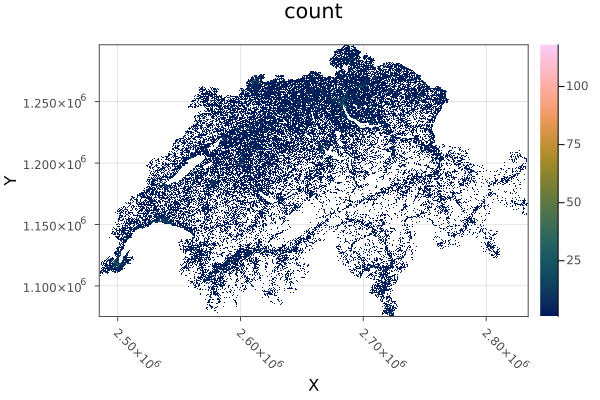

In [8]:
rl = rasterize(count, df.geom, to=mask, threaded=true)
plot(rl)

### Ecotone map
Ticks like the transition between forest and more open landcovers. Let's make an approximation by checking all landcover class borders morphologically.
Here I use the ESA WorldCover 2021 dataset, clipped to Switzerland. I disliked the 72 class provided dataset, as it was too detailed for my usecase here.

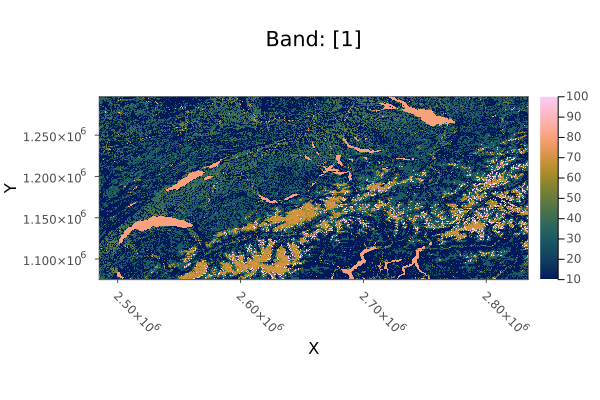

In [11]:
landcover = Raster(joinpath(folder, "esawc.tif"))
plot(landcover)

In [13]:
# Faster version from https://github.com/JuliaImages/ImageFiltering.jl/issues/179
function mapwindow2(f, img, window)
   out = zeros(eltype(img), axes(img))
   R = CartesianIndices(img)
   I_first, I_last = first(R), last(R)
   Δ = CartesianIndex(ntuple(x->window ÷ 2, ndims(img)))
   @inbounds @simd for I in R
       patch = max(I_first, I-Δ):min(I_last, I+Δ)
       out[I] = f(view(img, patch))
   end
   return out
end

mapwindow2 (generic function with 1 method)

We first make a map of all unique landcover classes in a 3x3 window. Higher counts indicate transitions.

In [14]:
using ImageFiltering
nlc = mapwindow2(x->length(unique(x)), landcover, 3);

Then we define our own window function (accepting only a 3x3 window) to find transitions between forest and open field-like landcovers, including water and urban.

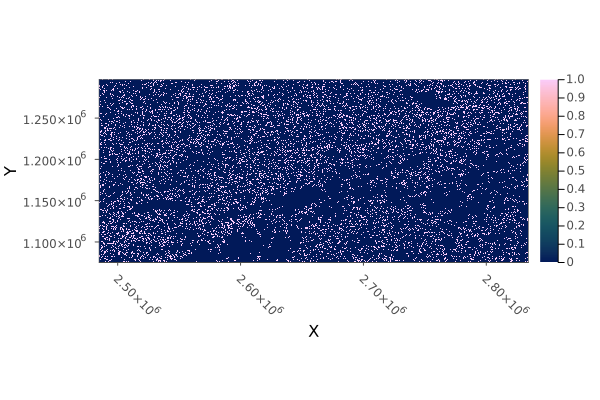

In [56]:
"""
This returns true if the middle cell of a 3x3 window is forest
and any of the surrounding pixels are grassland, shrubland, cropland, urban or water.
There are more classes, but they don't occur in Switzerland in large numbers.
"""
function ecotone_esa(view)
    view[2,2] == 10 && (20 in view || 30 in view || 40 in view || 50 in view || 80 in view)
end
ecotone = mapwindow2(ecotone_esa, landcover, 3)
plot(ecotone)

In [58]:
# Resample above derived datasets to the mask output for easy sampling later on
landcoverl = resample(landcover, to=mask)

# Copying for a small bug in Rasters.jl
ec = copy(landcover)
ec.= ecotone
ecotonel = resample(ec, to=mask)

nlcc = copy(landcover)
nlcc.= nlc
nlcl = resample(nlcc, to=mask);

### Elevation
Elevation is a useful metric because ticks do not occur on the glaciers and high mountains because of the lack of vegetation and cold.

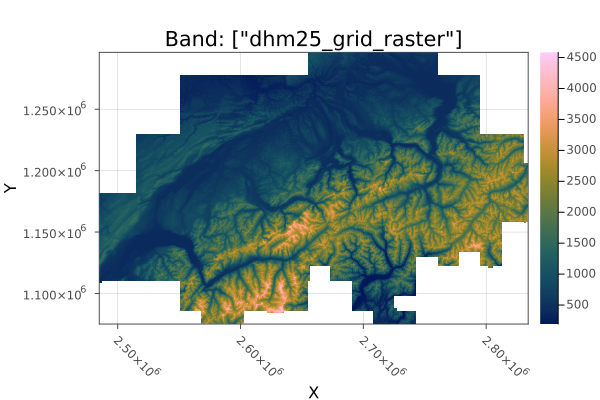

In [19]:
elevation = Raster(joinpath(folder, "DHM/DHM25_2056.tif"))
elevationl = resample(elevation, to=mask)
plot(elevationl)

## Training data
Read in the training points. Since these are all positive occurences (tickbite = yes), we are missing negative samples (tickbite = false). Ofcourse, these don't exist, so we need to invent them. This is the most influential decision for this hackathon, and a similar decision needs to be made for judging. Without negative samples our model will probably predict ticks *everywhere*.

In [26]:
training = GeoDataFrames.read(joinpath(folder, "../tick_reports_training.gpkg"))

28446×6 DataFrame
   Row │ geom                id     acc    datetime             X          Y   ⋯
       │ IGeometr…           Int32  Int32  DateTime             Float64    Flo ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ Geometry: wkbPoint     48     74  2015-03-11T21:09:27  2.70332e6  1.2 ⋯
     2 │ Geometry: wkbPoint     52     73  2015-03-11T20:39:01  2.70082e6  1.2
     3 │ Geometry: wkbPoint     59    257  2015-03-13T07:54:01  2.55911e6  1.1
     4 │ Geometry: wkbPoint     63    190  2015-03-14T16:38:27  2.60497e6  1.2
     5 │ Geometry: wkbPoint     66    333  2015-03-15T18:59:35  2.68172e6  1.2 ⋯
     6 │ Geometry: wkbPoint     67    257  2015-03-14T20:42:36  2.65859e6  1.2
     7 │ Geometry: wkbPoint     69     32  2015-03-16T09:41:24  2.55448e6  1.2
     8 │ Geometry: wkbPoint     70    257  2015-03-17T12:46:12  2.5814e6   1.1
     9 │ Geometry: wkbPoint     71    296  2015-03-16T19:28:28  2.68135e6  1.2 ⋯
    10 │ Geometry: wkbPoint     73    165  2015-03-17T11:53:33  2.72801e6  1.2
    11 │ Geometry: wkbPoint     75    257  2015-03-18T20:48:28  2.67471e6  1.2
   ⋮   │         ⋮             ⋮      ⋮             ⋮               ⋮          ⋱
 28437 │ Geometry: wkbPoint  49552    333  2020-12-18T19:45:02  2.64394e6  1.2
 28438 │ Geometry: wkbPoint  49553    333  2020-12-20T05:43:34  2.60587e6  1.1 ⋯
 28439 │ Geometry: wkbPoint  49554    301  2020-12-24T08:09:44  2.53022e6  1.1
 28440 │ Geometry: wkbPoint  49555    333  2020-12-24T16:09:17  2.61463e6  1.2
 28441 │ Geometry: wkbPoint  49557    128  2020-12-27T10:17:32  2.71132e6  1.1
 28442 │ Geometry: wkbPoint  49910    272  2020-06-02T06:48:58  2.71039e6  1.0 ⋯
 28443 │ Geometry: wkbPoint  49949    269  2020-07-04T06:45:50  2.69311e6  1.2
 28444 │ Geometry: wkbPoint  56372    969  2018-09-30T10:12:59  2.65095e6  1.2
 28445 │ Geometry: wkbPoint  58623    301  2016-08-20T17:53:09  2.62779e6  1.2
 28446 │ Geometry: wkbPoint  64904     97  2019-04-20T16:05:22  2.611e6    1.1 ⋯
                                                 1 column and 28425 rows omitted

### Absences
The above training dataset containst an accuracy of the reported measurements. To generate our negative sample, we will randomly sample the same amount of training observations, outside of the currently reported points with their accuracies.

In [91]:
pols = buffer.(training.geom, training.acc)  # polygons
x = rasterize(count, pols, to=mask, missingval=0, threaded=false)

# All cell indices without any reports
loc = findall(x.==0)

# A random 28k sample
ns = sample(loc, nrow(training))

# Convert these cell indices (CartesianIndex) to actual geometry points
nc = DimPoints(mask)[ns]
ng = ArchGDAL.createpoint.(nc)

Rasterizing... 100%|██████████████████████████████████████████████████| Time: 0:00:01
[ Info: 3127 geometries did not affect any pixels. See `metadata(raster)["missed_geometries"]` for a vector of misses


28446-element Vector{ArchGDAL.IGeometry{ArchGDAL.wkbPoint}}:
 Geometry: POINT (2641300 1214900)
 Geometry: POINT (2779700 1253300)
 Geometry: POINT (2666900 1089200)
 Geometry: POINT (2769700 1235700)
 Geometry: POINT (2741500 1136700)
 Geometry: POINT (2596200 1161700)
 Geometry: POINT (2794700 1211000)
 Geometry: POINT (2578900 1295900)
 Geometry: POINT (2679700 1184000)
 Geometry: POINT (2536200 1199800)
 Geometry: POINT (2648800 1246900)
 Geometry: POINT (2516400 1286600)
 Geometry: POINT (2805900 1227300)
 ⋮
 Geometry: POINT (2654100 1087300)
 Geometry: POINT (2754200 1263400)
 Geometry: POINT (2637800 1175800)
 Geometry: POINT (2771500 1191400)
 Geometry: POINT (2589500 1099800)
 Geometry: POINT (2717800 1079900)
 Geometry: POINT (2736900 1159500)
 Geometry: POINT (2785800 1238000)
 Geometry: POINT (2627100 1138700)
 Geometry: POINT (2503200 1258400)
 Geometry: POINT (2568600 1189100)
 Geometry: POINT (2645000 1180700)

In [92]:
# Create a new DataFrame that combines both occurrences and absences
ndf = DataFrame(geom=ng, class=0)
tdf = select(training, :geom)
tdf.class .= 1

adf = vcat(ndf, tdf)
GeoDataFrames.write("all.gpkg", adf, geom_columns=(:geom,))

"all.gpkg"

We plot a random subset (plotting all points takes too long on a default render) of points to validate the location of our newly added absences.

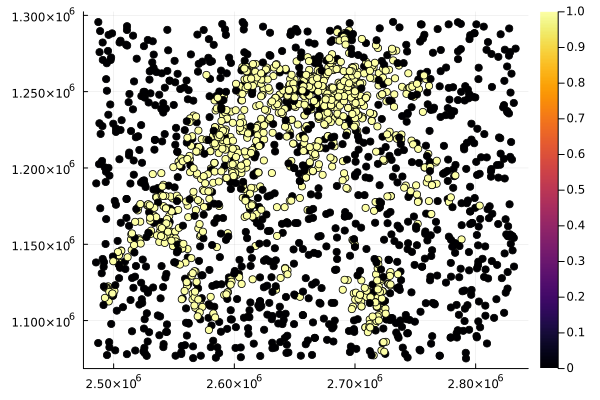

In [90]:
subset = sample(1:nrow(adf), 2000)
plot(adf.geom[subset], marker_z=adf.class[subset]', format=:png)

### Combining it all
With our new training data balanced, let's sample our features to create the actual training dataset for our model.

In [94]:
rs = RasterStack((;elevationl, roads=rl, landcover=landcoverl, ecotone=ecotonel, nlandcover=nlcl))

RasterStack with dimensions: 
  X Projected{Float64} LinRange{Float64}(2.485e6, 2.8339e6, 3490) ForwardOrdered Regular Intervals crs: WellKnownText,
  Y Projected{Float64} LinRange{Float64}(1.2959e6, 1.075e6, 2210) ReverseOrdered Regular Intervals crs: WellKnownText
and 5 layers:
  :elevationl Float32 dims: X, Y (3490×2210)
  :roads      Int64 dims: X, Y (3490×2210)
  :landcover  UInt8 dims: X, Y (3490×2210)
  :ecotone    UInt8 dims: X, Y (3490×2210)
  :nlandcover UInt8 dims: X, Y (3490×2210)


In [95]:
dft = DataFrame(extract(rs, adf.geom))  # extract samples the rasterstack at point positions
dft.class = adf.class  # add class to the sampled dataframe
GeoDataFrames.write("dft.gpkg", dft)
dft

56892×7 DataFrame
   Row │ geometry            elevationl  roads  landcover  ecotone  nlandcover ⋯
       │ IGeometr…           Float32     Int64  UInt8      UInt8    UInt8      ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ Geometry: wkbPoint     711.512      1         30        0           1 ⋯
     2 │ Geometry: wkbPoint    1287.07       0         10        0           1
     3 │ Geometry: wkbPoint     NaN          0         30        0           1
     4 │ Geometry: wkbPoint    1015.06       0         30        0           1
     5 │ Geometry: wkbPoint    2870.55       0         60        0           2 ⋯
     6 │ Geometry: wkbPoint    1261.65       1         10        0           1
     7 │ Geometry: wkbPoint    1354.16       0         30        0           1
     8 │ Geometry: wkbPoint     NaN          0         30        0           2
     9 │ Geometry: wkbPoint    1751.8        1         30        0           1 ⋯
    10 │ Geometry: wkbPoint    1145.73       1         30        0           1
    11 │ Geometry: wkbPoint     396.5        9         50        0           3
   ⋮   │         ⋮               ⋮         ⋮        ⋮         ⋮         ⋮      ⋱
 56883 │ Geometry: wkbPoint     441.858      3         10        1           2
 56884 │ Geometry: wkbPoint     672.889      2         10        0           1 ⋯
 56885 │ Geometry: wkbPoint     476.69      11         10        1           2
 56886 │ Geometry: wkbPoint     641.447      0         10        0           1
 56887 │ Geometry: wkbPoint     580.942      1         10        0           1
 56888 │ Geometry: wkbPoint     413.948      1         10        0           1 ⋯
 56889 │ Geometry: wkbPoint     521.935      1         40        0           1
 56890 │ Geometry: wkbPoint     327.531      7         10        1           2
 56891 │ Geometry: wkbPoint     425.202      2         10        0           1
 56892 │ Geometry: wkbPoint     682.191      0         30        0           1 ⋯
                                                 1 column and 56871 rows omitted

We need to let our ML model know some features are categories.

In [96]:
using ScientificTypes
dft.class = coerce(dft.class, Multiclass)
dft.landcover = coerce(dft.landcover, Multiclass)
dft.ecotone = coerce(dft.ecotone, Multiclass)

select!(dft, Not(:geometry))
schema(dft)

┌────────────┬────────────────┬─────────────────────────────────┐
│ names      │ scitypes       │ types                           │
├────────────┼────────────────┼─────────────────────────────────┤
│ elevationl │ Continuous     │ Float32                         │
│ roads      │ Count          │ Int64                           │
│ landcover  │ Multiclass{10} │ CategoricalValue{UInt8, UInt32} │
│ ecotone    │ Multiclass{2}  │ CategoricalValue{UInt8, UInt32} │
│ nlandcover │ Count          │ UInt8                           │
│ class      │ Multiclass{2}  │ CategoricalValue{Int64, UInt32} │
└────────────┴────────────────┴─────────────────────────────────┘


## Modeling
We use XGBoost (with default settings), as it is easy, fast and performs well.

In [97]:
# Pkg.add("MLJXGBoostInterface")
Tree = @load XGBoostClassifier pkg=XGBoost
tree = Tree()  # no hypertuning yet

[ Info: For silent loading, specify `verbosity=0`. 


import MLJXGBoostInterface ✔


XGBoostClassifier(
  test = 1, 
  num_round = 100, 
  booster = "gbtree", 
  disable_default_eval_metric = 0, 
  eta = 0.3, 
  num_parallel_tree = 1, 
  gamma = 0.0, 
  max_depth = 6, 
  min_child_weight = 1.0, 
  max_delta_step = 0.0, 
  subsample = 1.0, 
  colsample_bytree = 1.0, 
  colsample_bylevel = 1.0, 
  colsample_bynode = 1.0, 
  lambda = 1.0, 
  alpha = 0.0, 
  tree_method = "auto", 
  sketch_eps = 0.03, 
  scale_pos_weight = 1.0, 
  updater = nothing, 
  refresh_leaf = 1, 
  process_type = "default", 
  grow_policy = "depthwise", 
  max_leaves = 0, 
  max_bin = 256, 
  predictor = "cpu_predictor", 
  sample_type = "uniform", 
  normalize_type = "tree", 
  rate_drop = 0.0, 
  one_drop = 0, 
  skip_drop = 0.0, 
  feature_selector = "cyclic", 
  top_k = 0, 
  tweedie_variance_power = 1.5, 
  objective = "automatic", 
  base_score = 0.5, 
  watchlist = nothing, 
  nthread = 8, 
  importance_type = "gain", 
  seed = nothing, 
  validate_parameters = false, 
  eval_metric = String

We split our dataset into input and output.

In [98]:
y, x = unpack(dft, ==(:class); rng=123)

(CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 0, 1, 1, 1, 0, 0, 0, 1, 1  …  0, 1, 0, 1, 0, 1, 0, 0, 1, 1], 56892×5 DataFrame
   Row │ elevationl  roads  landcover  ecotone  nlandcover 
       │ Float32     Int64  Cat…       Cat…     UInt8      
───────┼───────────────────────────────────────────────────
     1 │   2051.35       1  30         0                 1
     2 │    447.443      3  10         0                 1
     3 │    469.101      3  10         0                 1
     4 │    348.177      6  50         0                 3
     5 │    530.609      2  10         0                 1
     6 │   2549.0        0  60         0                 2
     7 │    975.532      0  10         0                 1
     8 │   1362.45       0  30         0                 2
     9 │    564.383      2  30         0                 2
    10 │    450.751      4  10         1                 2
    11 │   1136.59       1  30         0                 2
   ⋮   │     ⋮         ⋮        ⋮     

And setup and run the model based on this dataset.

In [99]:
mach = machine(tree, x, y, scitype_check_level=0)

untrained Machine; caches model-specific representations of data
  model: XGBoostClassifier(test = 1, …)
  args: 
    1:	Source @777 ⏎ Table{Union{AbstractVector{Continuous}, AbstractVector{Count}, AbstractVector{Multiclass{10}}, AbstractVector{Multiclass{2}}}}
    2:	Source @766 ⏎ AbstractVector{Multiclass{2}}


In [100]:
pe = evaluate!(mach, resampling=StratifiedCV(; nfolds=6,
                               shuffle=true),
                 measures=[balanced_accuracy, kappa],
                 verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:10


PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌─────────────────────┬──────────────┬─────────────┬─────────┬──────────────────
│ measure             │ operation    │ measurement │ 1.96*SE │ per_fold        ⋯
├─────────────────────┼──────────────┼─────────────┼─────────┼──────────────────
│ BalancedAccuracy(   │ predict_mode │ 0.873       │ 0.00389 │ [0.877, 0.876,  ⋯
│   adjusted = false) │              │             │         │                 ⋯
│ Kappa()             │ predict_mode │ 0.745       │ 0.00779 │ [0.753, 0.752,  ⋯
└─────────────────────┴──────────────┴─────────────┴─────────┴──────────────────
                                                                1 column omitted


These numbers look quite good (and it is fast!), but ideally one would further investigate the feature importance and determine whether these loss functions work as they should.

## Prediction
With our trained model we can now make a prediction for the whole of Switzerland.

In [101]:
dfn = DataFrame(extract(rs, DimPoints(rs)))  # all values of the rasterstack as a row of points with attributes
select!(dfn, Not(:geometry))
dfn .= ifelse.(isinf.(dfn), 0.0, dfn)  # hard to predict with Inf
pred = predict_mode(mach, dfn)

7712900-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

We can reshape this answer into a Raster again, and make sure it adheres to the requirements (0=false, 100=true).

┌ Warning: `missing` cant be written to .tif, missinval for `UInt32` of `4294967295` used instead
└ @ Rasters ~/.julia/packages/Rasters/47MWf/src/utils.jl:32


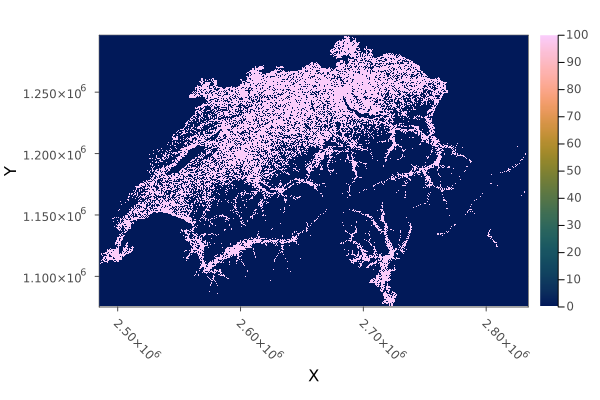

In [106]:
pr = Raster(int.(reshape(pred, size(rs)[1:2])), dims=dims(rs))
pr .-= 1  # Converting the CategoricalArray to int starts with 1
pr[mask.==255] .= 0  # Set values outside of Switzerland to false
pr .*= 100
Rasters.write("prediction.tif", pr, force=true)
plot(pr)

The above map is binary and will do badly in the hackathon (using logloss). Hence, using the prediction probability of each class will give us exactly what we need.

┌ Warning: `missing` cant be written to .tif, missinval for `UInt8` of `255` used instead
└ @ Rasters ~/.julia/packages/Rasters/47MWf/src/utils.jl:32


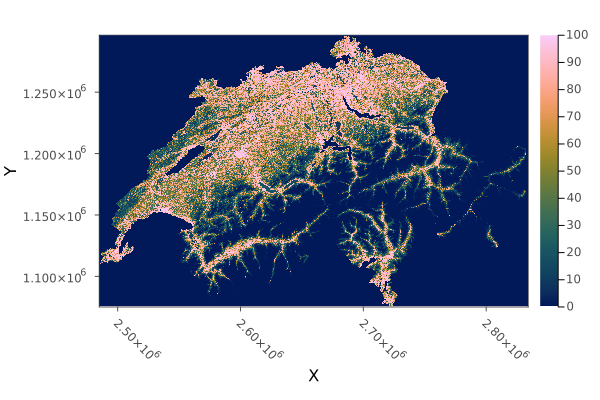

In [107]:
ppred = MLJ.predict(mach, dfn)  # note the difference with predict_mode above
ppr = Raster(reshape(pdf(ppred, [1]), size(rs)[1:2]), dims=dims(rs))  # pdf(ppred, [1]) gives us the probability for class 1
pprr = round.(UInt8, ppr * 100)  # to percentage in UInt8 instead of 0.x Float
pprr[mask.==255] .= 0  # Set values outside of Switzerland to false
Rasters.write("pprediction.tif", pprr, force=true)
plot(pprr)

Let's zoom in to see how we're doing

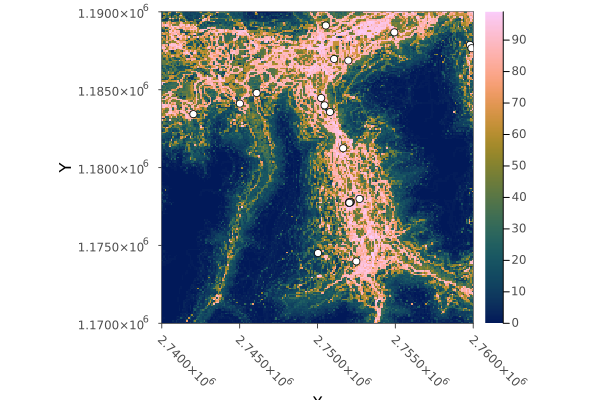

In [143]:
using GeoInterface, Extents
chur = view(pprr, X(2740000..2760000), Y(1170000..1190000))
x = plot(chur)
plot(x, tdf.geom[1:1000], c="white")

Overall this map looks pretty good, it seems most of the prediction is based on the road network. There are some buffered lines that might be the forest edge. There's also some noisy predictions, which might be smaller patches of either urban or open landcover (like pastures).